In [1]:
import sys
sys.path.insert(0, "../../src")
from earthtext.api import osmencoderauto
from earthtext.search import search
from progressbar import progressbar as pbar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# setup

- select a folder to hold model and data, `$OSMENCODER_FOLDER`

- copy into `$OSMENCODER_FOLDER` the following files
 
    - `s3://clay-text/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt`
    - `s3://clay-text/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.yaml`
    - `s3://clay-text/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet` 
    - `s3://clay-text/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2_embeddings_v1.0_meansstdevs.pkl`
 
- check that the property `metadata_file` on the `yaml` file points to the `parquet` file


# load and initialize helper object


In [2]:
model_ckpt_fname = '/opt/data/models/published/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt'
norm_constants_fname = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2_embeddings_v1.0_meansstdevs.pkl'
osmenc = osmencoderauto.OSMEncoderWithAutocompletion(model_ckpt_fname, norm_constants_fname)
osmenc.setup()

2024-05-22 01:16:11.856 | INFO     | earthtext.api.osmencoderauto:__init__:32 - osmencoder model is /opt/data/models/published/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt
2024-05-22 01:16:11.857 | INFO     | earthtext.api.osmencoderauto:__init__:33 - autocompletion source is 'train'
2024-05-22 01:16:11.863 | INFO     | earthtext.api.osmencoderauto:setup:51 - loading model
2024-05-22 01:16:11.920 | INFO     | earthtext.api.osmencoderauto:setup:55 - initializing dataloaders
2024-05-22 01:16:13.015 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 58690 chip files (out of 58690)
2024-05-22 01:16:13.016 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-22 01:16:13.467 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read val split with 11841 chip files (out of 11841)
2024-05-22 01:16:13.468 | INFO     | earthtext.datamodules.components.chipmu

In [3]:
searcher = search.OSMClayModelSearcher(model_ckpt_fname, search_target='train')

2024-05-22 01:16:27.379 | INFO     | earthtext.search.search:__init__:76 - search target is 'train'


In [4]:
searcher.setup()

2024-05-22 01:16:27.390 | INFO     | earthtext.search.search:setup:115 - loading model
2024-05-22 01:16:27.446 | INFO     | earthtext.search.search:setup:119 - initializing dataloaders
2024-05-22 01:16:28.022 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
2024-05-22 01:16:30.860 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 58598 chip files (out of 58690)
2024-05-22 01:16:30.861 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-22 01:16:31.411 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000:00
2024-05-22 01:16:31.973 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - re

# sanity check

In [6]:
if not sum([p.sum() for p in searcher.model.parameters()]) == sum([p.sum() for p in osmenc.model.parameters()]):
    raise ValueError("model mismatch in searcher and osmenc")

# measure precision for each tag

In [9]:
def get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples, query_min_counts=None, query_min_area_pct=None, n_search_samples=10, max_topn=50):

    if (query_min_area_pct is not None) + (query_min_counts is not None) != 1:
        raise ValueError(f"must set exactly one of 'query_min_area_pct' and 'query_min_counts'")
    
    chipm2 = 256*256*100 # how many square meters in a chip
    rset = []
    precs_at_topn = []

    # make user query vector
    tag_index_for_metric = np.argwhere(searcher.model.osm_tags_names==tag_name_for_metric)[0,0]
    min_counts, max_counts = {tag_name_for_metric: query_min_counts} if query_min_counts is not None else {}, {}
    min_areas,  max_areas  = {tag_name_for_metric: query_min_area_pct*chipm2} if query_min_area_pct is not None else {}  ,{}
        
    for _ in range(n_search_samples):
        
        # autocomplete and predict embeddings
        p = osmenc.predict_embedding(min_counts, max_counts, min_areas, max_areas)

        # normalize the embeddings
        p = osmenc.dataloader.normalizer.normalize_embeddings(p)

        # search in normalized space
        r = searcher.make_search(p, topn=None)
        rset.append(r)
    
        # measure precision at topn, with n = 1..max_topn
        prec_at_topn = {k: (r['original_osm_vectors']['osm_ohecount'][:, searcher.model.osm_tags_indexes][:, tag_index_for_metric][:k]>1).mean()\
                        for k in range(1,max_topn+1)}
        precs_at_topn.append(prec_at_topn)
    return precs_at_topn
    

# querying for min area 1% of chip

In [20]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples=10, query_min_area_pct=.01, n_search_samples=5, max_topn=50)
                                    for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}


 88% (22 of 25) |#####################   | Elapsed Time: 0:01:39 ETA:   0:00:13/home/ubuntu/earth-text/notebooks/api/../../src/earthtext/api/osmencoderauto.py:119: RuntimeWarning: Mean of empty slice.
  query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100% (25 of 25) |########################| Elapsed Time: 0:01:52 Time:  0:01:5204


In [21]:
class_prec_means = {i: pd.DataFrame(pr[i]).mean(axis=1).mean() for i in pr.keys()}
class_prec_stds  = {i: pd.DataFrame(pr[i]).mean(axis=1).std() for i in pr.keys()}

Text(0.5, 1.0, 'querying for min area > 1%')

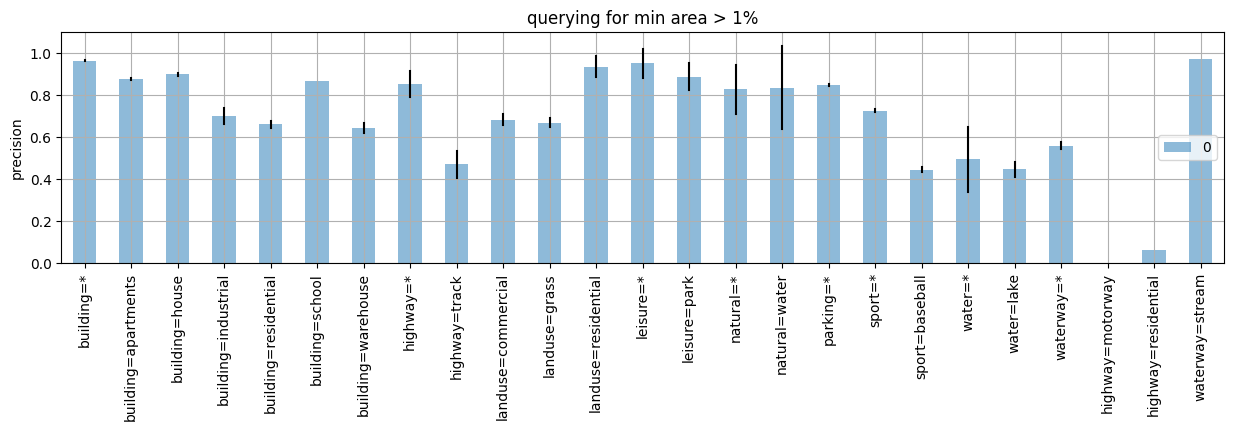

In [23]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")
plt.ylim(0,1.1)
plt.title("querying for min area > 1%")

# querying for count > 10

In [24]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples=10, query_min_counts=10, n_search_samples=5, max_topn=50)
                                    for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}


100% (25 of 25) |########################| Elapsed Time: 0:01:50 Time:  0:01:500413


In [25]:
class_prec_means = {i: pd.DataFrame(pr[i]).mean(axis=1).mean() for i in pr.keys()}
class_prec_stds  = {i: pd.DataFrame(pr[i]).mean(axis=1).std() for i in pr.keys()}

Text(0.5, 1.0, 'querying for counts > 10')

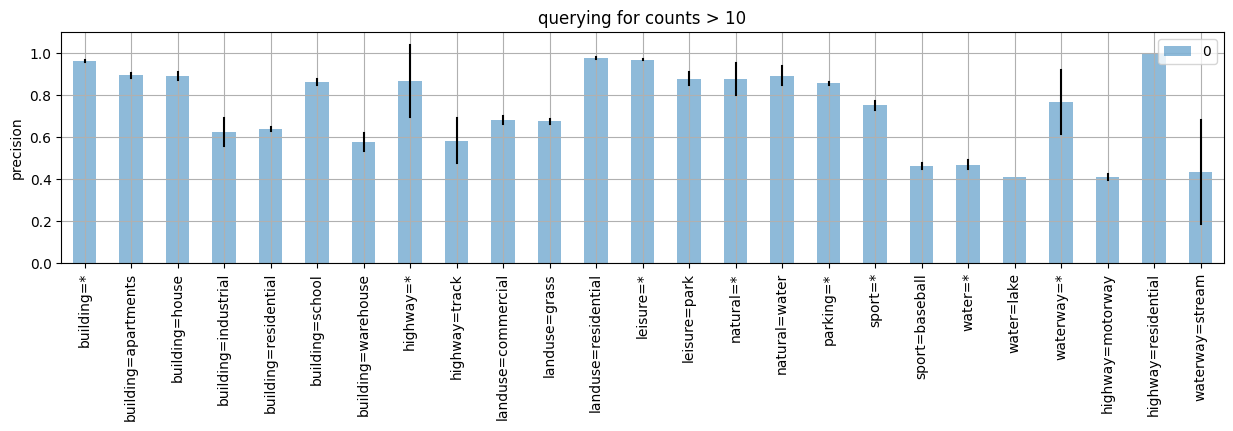

In [26]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")
plt.ylim(0,1.1)
plt.title("querying for counts > 10")